In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P1'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here are our files:")
!ls -lasth

Mounted at /content/gdrive
Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P1'
/content/gdrive/MyDrive/GIA/VCA/P1
/content/gdrive/MyDrive/GIA/VCA/P1

And here are our files:
total 4.0K
4.0K drwx------ 2 root root 4.0K Apr  2 20:34 ship_dataset


#### Importamos las bibliotecas necesarias para realizar la práctica.

In [2]:
import os, glob, time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

seed = 42
batch_size = 64

## **Tarea 1**: Implementación de Dataset class personalizada para la carga del dataset y su uso en tareas de clasificación.

#### Creamos una clase `Dataset` que hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [3]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()
        self.img_files = glob.glob(os.path.join(image_path, "*.jpg")) + glob.glob(os.path.join(image_path, "*.png"))
        print("Imágenes en .jpg y .png:", len(self.img_files))

        # leemos el csv y recortamos la cabecera
        self.labels = open(csv_path).readlines()[1:]

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        img_path = self.img_files[index]

        name = os.path.splitext(os.path.basename(img_path))[0]

        image = read_image(img_path)
        image = self.transform(image)

        # nos quedamos solo con la etiqueta binaria
        line = self.labels[index].strip()
        _, label = line.split(";")
        label = torch.tensor(int(label), dtype=torch.float32)

        return image, label, name

    def __len__(self):
        return len(self.img_files)

#### Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [4]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

#### Indicamos el directorio de las imágenes y el archivo CSV de etiquetas. Creamos transformaciones personalizadas para las imágenes e instanciamos el dataset ship_dataset. Finalmente, imprimimos el tamaño del dataset.

In [5]:
dir = "ship_dataset"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en .jpg y .png: 294
Tamaño del dataset completo: 294


####  Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

<ipython-input-4-165f0e13db72>:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  new_image[:,:] = tensor[0,:,:]


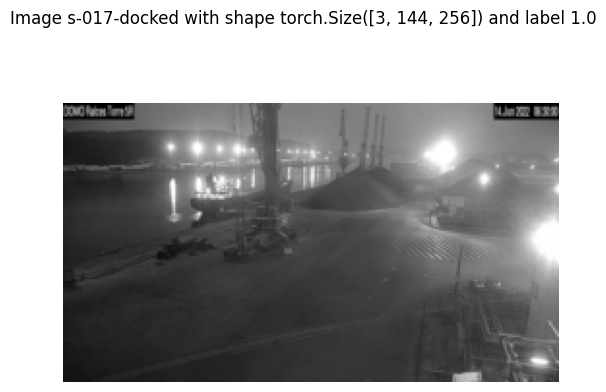

In [6]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

#### Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [7]:
model = squeezenet1_0(weights=None)
#print(model)

In [8]:
mymodel_no_da = nn.Sequential(
    model.features,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

image = image.unsqueeze(0)

output = mymodel_no_da(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship. Dada una imagen de entrada predecir la presencia o ausencia de barcos en la escena. Partiendo de un modelo de red base:

### Entrenamiento y validación desde cero, con y sin data augmentation (2 modelos)

In [9]:
# 60-20-20
train_indices, test_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)
test_dataset = data.Subset(ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
def train_model(model, train_loader, val_loader, loss_fn, optim, device, model_name, epochs=20):
    print("Device:", device)
    model.to(device)

    train_losses, val_losses = list(), list()

    for epoch in range(epochs):
        start_time = time.time()

        model.train() # modo train

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        model.eval() # modo evaluación
        val_loss = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}],",
              f"train loss: {train_loss:.4f},",
              f"val loss: {val_loss:.4f},",
              f"time: {(time.time() - start_time):.2f}s")

    torch.save(model.state_dict(), f"{model_name}.pth")

    return model, train_losses, val_losses

def plot_history(train, val):
    plt.clf()
    plt.plot(train, label="train")
    plt.plot(val, label="validation")
    plt.legend(loc="upper right")
    plt.show()

#### Sin Data Augmentation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA",
                                                epochs=50)

Device: cuda:0
Epoch [1/50], train loss: 0.6322, val loss: 0.6962, time: 15.31s
Epoch [2/50], train loss: 0.6937, val loss: 0.6875, time: 7.81s
Epoch [3/50], train loss: 0.6674, val loss: 0.6655, time: 6.41s
Epoch [4/50], train loss: 0.6171, val loss: 0.6882, time: 7.81s
Epoch [5/50], train loss: 0.6284, val loss: 0.6589, time: 6.49s
Epoch [6/50], train loss: 0.6396, val loss: 0.6575, time: 7.47s
Epoch [7/50], train loss: 0.6102, val loss: 0.6563, time: 6.52s
Epoch [8/50], train loss: 0.5981, val loss: 0.6402, time: 9.31s
Epoch [9/50], train loss: 0.5793, val loss: 0.6468, time: 6.45s
Epoch [10/50], train loss: 0.5681, val loss: 0.6239, time: 7.59s
Epoch [11/50], train loss: 0.5452, val loss: 0.6553, time: 6.49s
Epoch [12/50], train loss: 0.5573, val loss: 0.6044, time: 7.52s
Epoch [13/50], train loss: 0.5060, val loss: 0.6625, time: 6.47s
Epoch [14/50], train loss: 0.5445, val loss: 0.6232, time: 8.99s
Epoch [15/50], train loss: 0.4862, val loss: 0.6573, time: 6.35s
Epoch [16/50], tra

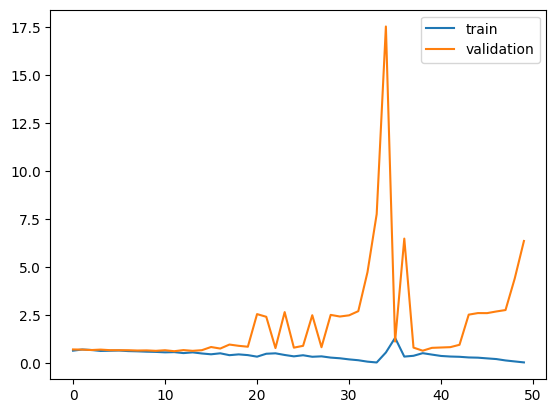

In [12]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [13]:
# Definimos las transformaciones con redimensionamiento y data augmentation
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)

train_dataset = data.Subset(augmented_ship_dataset, train_indices)
val_dataset = data.Subset(augmented_ship_dataset, val_indices)
# test_dataset = data.Subset(augmented_ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
# test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

Imágenes en .jpg y .png: 294


In [14]:
# Definimos el modelo
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA",
                                                    epochs=75)

Device: cuda:0
Epoch [1/75], train loss: 0.6403, val loss: 0.6683, time: 8.20s
Epoch [2/75], train loss: 0.6247, val loss: 0.7122, time: 6.74s
Epoch [3/75], train loss: 0.6494, val loss: 0.6716, time: 7.45s
Epoch [4/75], train loss: 0.6589, val loss: 0.6648, time: 7.12s
Epoch [5/75], train loss: 0.6240, val loss: 0.6534, time: 7.16s
Epoch [6/75], train loss: 0.6009, val loss: 0.6471, time: 7.28s
Epoch [7/75], train loss: 0.6131, val loss: 0.6349, time: 6.75s
Epoch [8/75], train loss: 0.5730, val loss: 0.6568, time: 7.39s
Epoch [9/75], train loss: 0.6070, val loss: 0.5947, time: 6.67s
Epoch [10/75], train loss: 0.5458, val loss: 0.5937, time: 7.65s
Epoch [11/75], train loss: 0.5117, val loss: 0.6871, time: 6.41s
Epoch [12/75], train loss: 0.6359, val loss: 0.6259, time: 7.61s
Epoch [13/75], train loss: 0.4994, val loss: 0.5880, time: 6.43s
Epoch [14/75], train loss: 0.5307, val loss: 0.5823, time: 7.63s
Epoch [15/75], train loss: 0.4677, val loss: 0.6506, time: 6.39s
Epoch [16/75], trai

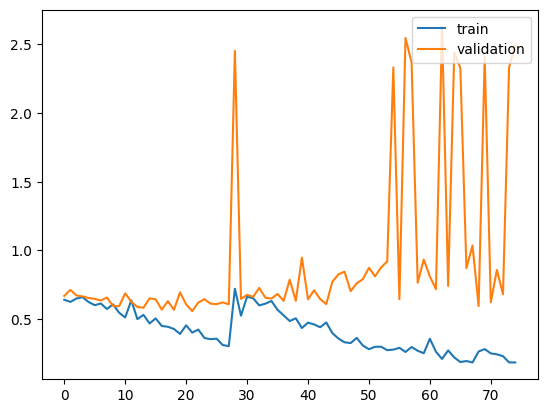

In [16]:
plot_history(train_losses, val_losses)

In [17]:
def accuracy(outputs, targets):
    predicted = (outputs > 0.5).squeeze(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return correct/total

def test_model(model, test_loader):
    print("Device:", device)
    model.eval()

    mean_acc = 0

    with torch.no_grad(): # This disables autograd
        for i, (samples, targets, _) in enumerate(test_loader):
            samples = samples.to(device)
            targets = targets.to(device)

            outputs = model(samples)

            this_acc = accuracy(outputs, targets)

            mean_acc += this_acc

        mean_acc /= (i+1)

    print(f"test accuracy: {(mean_acc*100):.2f} %")

In [18]:
test_model(mymodel_no_da, test_loader)
test_model(mymodel_da, test_loader)

Device: cuda:0
test accuracy: 77.97 %
Device: cuda:0
test accuracy: 72.88 %


---------------------------------------------------------------------------------------------------------------------------------------

### Refinamiento y validación de modelo preentrenado, con y sin data augmentation (2 modelos).

### Sin Data Augmentation

In [19]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Modificamos la última capa del modelo
pretrained_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
pretrained_model.num_classes = 1

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

# Entrenamos el modelo preentrenado
num_epochs = 20
for epoch in range(num_epochs):
    pretrained_model.train()
    for images, labels, _ in train_loader:
        labels = labels.float().unsqueeze(1)
        outputs = pretrained_model(images)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validamos el modelo
    pretrained_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            labels = labels.float().unsqueeze(1)
            outputs = pretrained_model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 104MB/s]


Epoch [1/20], Loss: 0.6679, Val Loss: 0.6679
Epoch [2/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [3/20], Loss: 0.6557, Val Loss: 0.6557
Epoch [4/20], Loss: 0.6338, Val Loss: 0.6338
Epoch [5/20], Loss: 0.6041, Val Loss: 0.6041
Epoch [6/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [7/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [8/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [9/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [10/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [11/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [12/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [13/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [14/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [15/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [16/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [17/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [18/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [19/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [20/20], Loss: 0.6931, Val Loss: 0.6931


#### Con Data Augmentation

In [22]:
# Creamos un nuevo dataset con el data augmentation
# Definimos las transformaciones con redimensionamiento y data augmentation (Si no lo has hecho antes)
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=train_transforms)


# Dividimos el dataset en entrenamiento y validación
train_indices, val_indices = train_test_split(list(range(len(augmented_ship_dataset))), test_size=0.2, random_state=seed)

train_dataset = data.Subset(augmented_ship_dataset, train_indices)
test_dataset = data.Subset(augmented_ship_dataset, val_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Entrenamos el modelo preentrenado con data augmentation
#num_epochs = 20
#for epoch in range(num_epochs):
#    pretrained_model.train()
#    for images, labels, _ in train_loader:
#        labels = labels.float().unsqueeze(1)
#        outputs = pretrained_model(images)
#        outputs = torch.sigmoid(outputs)
#        loss = criterion(outputs, labels)
#
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#
#    # Validamos el modelo
#    pretrained_model.eval()
#    val_loss = 0
#    with torch.no_grad():
#        for images, labels, _ in val_loader:
#            labels = labels.float().unsqueeze(1)
#            outputs = pretrained_model(images)
#            outputs = torch.sigmoid(outputs)
#            loss = criterion(outputs, labels)
#            val_loss += loss.item()
#
#    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Modificamos la última capa del modelo
pretrained_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
pretrained_model.num_classes = 1

# Move the model to the appropriate device
pretrained_model.to(device)

# Unfreeze the model weights for fine-tuning
for param in pretrained_model.parameters():
    param.requires_grad = True

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

# Entrenamos el modelo preentrenado
num_epochs = 20
for epoch in range(num_epochs):
    pretrained_model.train()
    for images, labels, _ in train_loader:
        # Move data to the same device as the model
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = pretrained_model(images)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validamos el modelo
    pretrained_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            # Move data to the same device as the model
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = pretrained_model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Imágenes en .jpg y .png: 294
Epoch [1/20], Loss: 0.7367, Val Loss: 0.7367
Epoch [2/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [3/20], Loss: 0.6711, Val Loss: 0.6711
Epoch [4/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [5/20], Loss: 0.6932, Val Loss: 0.6932
Epoch [6/20], Loss: 0.6929, Val Loss: 0.6929
Epoch [7/20], Loss: 0.6932, Val Loss: 0.6932
Epoch [8/20], Loss: 0.6769, Val Loss: 0.6769
Epoch [9/20], Loss: 0.6793, Val Loss: 0.6793
Epoch [10/20], Loss: 0.6823, Val Loss: 0.6823
Epoch [11/20], Loss: 0.6813, Val Loss: 0.6813
Epoch [12/20], Loss: 0.6504, Val Loss: 0.6504
Epoch [13/20], Loss: 0.6467, Val Loss: 0.6467
Epoch [14/20], Loss: 0.6847, Val Loss: 0.6847
Epoch [15/20], Loss: 0.6900, Val Loss: 0.6900
Epoch [16/20], Loss: 0.6666, Val Loss: 0.6666
Epoch [17/20], Loss: 0.6819, Val Loss: 0.6819
Epoch [18/20], Loss: 0.6529, Val Loss: 0.6529
Epoch [19/20], Loss: 0.6415, Val Loss: 0.6415
Epoch [20/20], Loss: 0.6896, Val Loss: 0.6896
